In [4]:
import torch
import pandas as pd
import numpy as np

rng = np.random.default_rng()

In [43]:
# Following this tutorial: https://machinelearningmastery.com/joining-the-transformer-encoder-and-decoder-and-masking/
# Modified for PyTorch

#class TransformerAugmentations():
def padding_mask(input, pad_idx=0):
    # Create mask which marks the zero padding values in the input by a 1
    mask = input == pad_idx
    #mask = mask.float()

    return mask

def lookahead_mask(shape):
    # Mask out future entries by marking them with a 1.0
    mask = 1 - torch.tril(torch.ones((shape, shape)))
    mask = mask.masked_fill(mask == 1, float('-inf'))
 
    return mask


In [44]:
shape = 10
test_input = torch.ones((shape))
test_input[5:] = 0
p_mask = padding_mask(test_input)
print(p_mask)
print(p_mask.shape)
l_mask = lookahead_mask(shape)
print(l_mask)
print(test_input * p_mask)


tensor([False, False, False, False, False,  True,  True,  True,  True,  True])
torch.Size([10])
tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


# Test dataset class

In [7]:
import glob
valid_files = glob.glob("/root/data/smartwatch/subjects/*/*_full.csv")
len(valid_files)

655

In [8]:
import numpy as np
import random
import math

all_subjects = np.arange(40) + 1

random.shuffle(all_subjects)
all_subjects
num_test_patients = 6
num_val_patients = 1

num_k_folds = math.floor(40/7)

for i in np.arange(num_k_folds):
    print(f"Group {i+1}")
    print(f"\tTest Subject: {all_subjects[i*7]}")
    for j in np.arange(6):
        print(f"\tVal Subject: {all_subjects[i*7 + j + 1]}")


Group 1
	Test Subject: 4
	Val Subject: 35
	Val Subject: 39
	Val Subject: 17
	Val Subject: 5
	Val Subject: 12
	Val Subject: 13
Group 2
	Test Subject: 31
	Val Subject: 26
	Val Subject: 7
	Val Subject: 18
	Val Subject: 10
	Val Subject: 33
	Val Subject: 40
Group 3
	Test Subject: 1
	Val Subject: 11
	Val Subject: 8
	Val Subject: 24
	Val Subject: 21
	Val Subject: 27
	Val Subject: 9
Group 4
	Test Subject: 34
	Val Subject: 32
	Val Subject: 29
	Val Subject: 6
	Val Subject: 14
	Val Subject: 15
	Val Subject: 19
Group 5
	Test Subject: 30
	Val Subject: 22
	Val Subject: 20
	Val Subject: 36
	Val Subject: 38
	Val Subject: 16
	Val Subject: 2


In [44]:

class SmartwatchDataset(torch.utils.data.Dataset):
    def __init__(self, valid_files, sample_period=0.02):
        """
        Parameters:
        -----------
        valid_files: list of filepaths to normalized data
        """
        super().__init__()
        self.data = []
        for file in valid_files:
            df = pd.read_csv(file)
            # Resample the data if needed
            df.index = pd.to_timedelta(df["time"], unit="seconds")
            df = df.drop("time", axis=1)
            df = df.resample(f"{sample_period}S").mean()
            self.data.append(df.values)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        """Returns tuple of (imu, mocap) at index"""
        item = self.data[index]
        imu = item[:, 0:9]  # IMU sensor data [accel, mag, gyro]
        mocap = item[:, 9:]  # Mocap data [pos, quat]
        return imu, mocap
    

class SmartwatchAugmentTransformer:
    """
    Collate function to apply random augmentations to the data
        - Randomly perturb the mocap positions
        - Randomly flip sign of mocap quaternion
        - Add random noise to IMU channels
        - Random crop to the signal (if possible)
    """
    def __init__(self, position_noise=0.2, accel_eps=0.01, gyro_eps=0.01, mag_eps=0.01, max_samples=512, num_heads=8):
        """
        Parameters:
        -----------
        position_noise: float, limits on uniform distribution [-p, p] to add position offset to mocap
        accel_eps: float, standard deviation on Gaussian noise added to accelerometer channels
        gyro_eps: float, standard deviation on Gaussian noise added to gyroscope channels
        mag_eps: float, standard deviation on Gaussian noise added to mangetometer channels
        """
        self.position_noise = position_noise
        self.accel_eps = accel_eps
        self.gyro_eps = gyro_eps
        self.mag_eps = mag_eps
        self.max_samples = max_samples
        self.num_heads = num_heads

    def _random_crop(self, imu, mocap):
        """
        Apply a random crop of the signal of length self.max_samples to both inputs and labels, if able to
        Due to targets being a shifted version of decoder inputs, we need to account for one extra timepoint
        """
        n, d = imu.shape
        max_offset = n - self.max_samples - 1

        if max_offset > 0:
            offset = rng.choice(max_offset)
            inds = slice(offset, offset + self.max_samples + 1)
            return imu[inds, :], mocap[inds, :]
        else:
            return imu, mocap
        

    def padding_mask(self, input, pad_idx=0, dim=512, num_heads=8): 
        # Create mask which marks the zero padding values in the input by a 0
        mask = torch.zeros((dim))
        if input.shape[0] < dim:
            mask[input.shape[0]:] = 1
            return mask.bool()
        #mask = mask.float()

        return mask.bool()


    def lookahead_mask(self, shape):
        # Mask out future entries by marking them with a 1.0
        mask = 1 - torch.tril(torch.ones((shape, shape)))
        mask = mask.masked_fill(mask == 1, float('-inf'))
    
        return mask


    def __call__(self, data):
        """
        Parameters:
        -----------
        data: list of tuple of (imu, mocap) of length batch_size
            imu: np.ndarray, dimensions (n_samples, 9), signal data for IMU accel, gyro, and mag
            mocap: np.ndarray, dimensions (n_samples, 7), position and quaternion data from mocap

        Returns:
        --------
        collated_data: dict of torch.nn.utils.rnn.PackedSequence with keys ["encoder_inputs", "decoder_inputs", "targets"]
        """
        encoder_inputs = []
        decoder_inputs = []
        targets = []
        for (imu, mocap) in data:
            imu, mocap = self._random_crop(imu, mocap)

            n_in, d_in = imu.shape
            n_out, d_out = mocap.shape
            assert n_in == n_out, "IMU and mocap must have the same number of sequence elements"
            assert d_in == 9, f"IMU data has dimensionality {d_in} instead of 9"
            assert d_out == 7, f"Mocap data has dimensionality {d_out} instead of 7"

            # Augment XYZ positions
            offset = rng.uniform(-self.position_noise, self.position_noise, size=(1, 3))
            mocap[:, 0:3] += offset
            # Augment quaternion sign
            sign = rng.choice([-1, 1])
            mocap[:, 4:] *= sign

            accel_noise = rng.normal(loc=0, scale=self.accel_eps, size=(n_in, 3))
            gyro_noise = rng.normal(loc=0, scale=self.gyro_eps, size=(n_in, 3))
            mag_noise = rng.normal(loc=0, scale=self.mag_eps, size=(n_in, 3))

            noise = np.hstack([accel_noise, gyro_noise, mag_noise])
            imu += noise

            # Ensure targets are one timestep shifted wrt inputs
            encoder_inputs.append(torch.FloatTensor(imu[:-1, :]))
            decoder_inputs.append(torch.FloatTensor(mocap[:-1, :]))
            targets.append(torch.FloatTensor(mocap[1:, :]))

        lengths = [len(item) for item in encoder_inputs]
        inds = np.flip(np.argsort(lengths)).copy()  # PackedSequence expects lengths from longest to shortest
        lengths = torch.LongTensor(lengths)[inds]

        # Sort by lengths
        encoder_inputs = [encoder_inputs[i] for i in inds]
        decoder_inputs = [decoder_inputs[i] for i in inds]
        targets = [targets[i] for i in inds]

        # Padding mask for encoder
        enc_padding_mask = [self.padding_mask(input=encoder_inputs[i]) for i in inds]
        enc_lookahead_mask = [self.lookahead_mask(shape=encoder_inputs[i].shape[0]) for i in inds]
        
        # Padding and look-ahead masks for decoder
        dec_in_padding_mask = [self.padding_mask(input=decoder_inputs[i]) for i in inds]
        dec_in_lookahead_mask = [self.lookahead_mask(shape=decoder_inputs[i].shape[0]) for i in inds]
        #dec_in_lookahead_mask = [torch.maximum(dec_in_padding_mask[i], dec_in_lookahead_mask[i]) for i in inds]

        # Pad input, if needed
        for i, length in enumerate(lengths):
            if length != 512:
                print("Dim does not equal 512 - padding sequence") 
                encoder_inputs[i] = torch.nn.functional.pad(encoder_inputs[i], pad=(0, 512 - encoder_inputs[i].shape[0]), mode='constant', value=0)
                decoder_inputs[i] = torch.functional.pad(decoder_inputs[i], pad=(0, 512 - decoder_inputs[i].shape[0]), mode='constant', value=0)
                targets[i] = torch.functional.pad(targets[i], pad=(0, 512 - targets[i].shape[0]), mode='constant', value=0)

        encoder_inputs = torch.stack(encoder_inputs)
        decoder_inputs = torch.stack(decoder_inputs)
        targets = torch.stack(targets)

        enc_padding_mask = torch.stack(enc_padding_mask)
        enc_padding_mask =enc_padding_mask.repeat(self.num_heads, 1)
        enc_lookahead_mask = torch.stack(enc_lookahead_mask)
        enc_lookahead_mask =enc_lookahead_mask.repeat(self.num_heads, 1, 1)
        dec_in_padding_mask = torch.stack(dec_in_padding_mask)
        dec_in_padding_mask = dec_in_padding_mask.repeat(self.num_heads,1)
        dec_in_lookahead_mask = torch.stack(dec_in_lookahead_mask)
        dec_in_lookahead_mask = dec_in_lookahead_mask.repeat(self.num_heads, 1, 1)

        collated_data = {
            "encoder_inputs": encoder_inputs,
            "decoder_inputs": decoder_inputs,
            "targets": targets,
            "encoder_padding_mask": enc_padding_mask,
            "decoder_padding_mask": dec_in_padding_mask,
            "decoder_lookahead_mask": dec_in_lookahead_mask,
            "encoder_lookahead_mask": enc_lookahead_mask
        }
        return collated_data

def get_file_lists():
    """Get list of files to pass to dataset class
    Returns:
    --------
    train_files: list of str filepaths to pre-processed train data
    test_files: list of str filepaths to pre-processed test data
    """
    import glob
    valid_files = glob.glob("/root/data/smartwatch/subjects/*/*_full.csv")
    test_subjects = [f"S{n}" for n in [5, 10, 15, 20, 25, 30]]
    test_files = [file for file in valid_files for subject in test_subjects if f"/{subject}/" in file]
    train_files = [file for file in valid_files if file not in set(test_files)]
    return train_files, test_files


In [31]:
dataset = SmartwatchDataset(valid_files)

In [45]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, collate_fn=SmartwatchAugmentTransformer())

In [46]:
batch = next(iter(dataloader))

In [12]:
batch['encoder_padding_mask']

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [47]:
print(batch['encoder_inputs'].data.shape)
print(batch['encoder_padding_mask'].data.shape)
print(batch['encoder_lookahead_mask'].data.shape)
print(batch['decoder_inputs'].data.shape)
print(batch['decoder_padding_mask'].data.shape)
print(batch['decoder_lookahead_mask'].data.shape)

torch.Size([16, 512, 9])
torch.Size([128, 512])
torch.Size([128, 512, 512])
torch.Size([16, 512, 7])
torch.Size([128, 512])
torch.Size([128, 512, 512])


In [10]:
# Testing incrementally adding to the masks
source_padding = batch['encoder_padding_mask']
target_padding = batch['decoder_padding_mask']
target_lookahead = batch['decoder_lookahead_mask']

source_padding_step = source_padding[:, 0]
target_padding_step = target_padding[:, 0]
target_lookahead_step = target_lookahead[:, 0, :]

In [11]:
source_padding_step = source_padding[:, :2]
source_padding_step

tensor([[False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False]])

In [ ]:
for i in range(1, 512):
    
    start = train_target_unpacked[:, i, :].unsqueeze(1)
    encoder_hidden = decoder_hidden
    encoder_cell = decoder_cell

# Testing Tranformer Model Class

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
import os
import glob
import time
from datetime import datetime
import matplotlib.pyplot as plt
import math
import random

import model.hyperparameters as hp

from utils.dataset import (
    SmartwatchDataset, 
    SmartwatchAugmentTransformer, 
    get_file_lists
)

%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)

        pe[:, 0, 0::2] = torch.sin(position * div_term)
        if d_model % 2 != 0:
            pe[:, 0, 1::2] = torch.cos(position * div_term)[:, :-1]
        else:
            pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# class PositionalEncoding(torch.nn.Module):
#     def __init__(self, dim_model, dropout_p, max_len):
#         super().__init__()
#         # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
#         # max_len determines how far the position can have an effect on a token (window)
        
#         # Info
#         self.dropout = torch.nn.Dropout(dropout_p)
        
#         # Encoding - From formula
#         pos_encoding = torch.zeros(max_len, dim_model)
#         positions_list = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) # 0, 1, 2, 3, 4, 5
#         division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
#         # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
#         pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
#         # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
#         pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
#         # Saving buffer (same as parameter without gradients needed)
#         pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
#         self.register_buffer("pos_encoding",pos_encoding)

#     def forward(self, token_embedding: torch.tensor) -> torch.tensor:
#         # Residual connection + pos encoding
#         return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])
    
class MyPositionalEncoding(torch.nn.Module):  # custom code
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(MyPositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros((max_len, 1, d_model), 
                        dtype=torch.float32)
        factor = -math.log(10000.0) / d_model  # outs loop
        for pos in range(0, max_len):  # position of word in seq
            for i in range(0, d_model, 2):  # pos of embed of word
                div_term = math.exp(i * factor)
                pe[pos, 0, i] = math.sin(pos * div_term)
                pe[pos, 0, i+1] = math.cos(pos * div_term)

        self.register_buffer('pe', pe)  # allows state-save

    def forward(self, x):
        # x has shape [seq_len, bat_size, embed_dim]
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [3]:
d_model = 9
dropout = 0.5
positional_encoder = PositionalEncoding(
            d_model=d_model, dropout=dropout, max_len=5000
)

In [4]:
class CNNModel(nn.Module):
    def __init__(self, input_features=30, mp=2):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv1d(input_features, 32, kernel_size=32, padding=16)
        self.mp = nn.MaxPool1d(mp, stride=mp)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=16, padding="same")

        self.conv3 = nn.Conv1d(64, 128, kernel_size=8, padding="same")

        self.conv4 = nn.Conv1d(128, 256, kernel_size=4, padding="same")


    def forward(self, x):
        """
        Parameters:
        -----------
        x : torch.tensor
            Inputs, of shape (batch, sequence, channels)
        Returns:
        --------
        y : torch.tensor
            Outputs, of shape (batch, sequence, channels)
        """
        x = x.permute(0, 2, 1)  # Permute dims for convolution
        x = self.conv1(x)
        # print(x.shape)
        x = torch.nn.functional.relu(x)
        x = self.mp(x)

        x = self.conv2(x)
        # print(x.shape)
        x = torch.nn.functional.relu(x)
        x = self.mp(x)

        x = self.conv3(x)
        # print(x.shape)
        x = torch.nn.functional.relu(x)
        
        x = self.conv4(x)
        x = torch.nn.functional.relu(x)
        x = self.mp(x)
        # print(x.shape)
        y = x.permute(0, 2, 1)  # Permute dims for input to transformer
        return y

In [5]:
class TransformerModel(torch.nn.Module):
    def __init__(self, input_size=9, output_size=7, d_model=32, n_heads=8, dropout=0.1, num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()
        # INFO
        self.model_type = "Transformer"
        self.d_model = d_model

        self.input_transform = nn.Linear(input_size, d_model)
        self.target_transform = nn.Linear(output_size, d_model)

        # LAYERS
        self.positional_encoder = PositionalEncoding(
            d_model=d_model, dropout=dropout, max_len=5000
        )

        
        #self.embedding = torch.nn.Embedding(num_tokens, d_model)
        

        self.transformer = torch.nn.Transformer(
            d_model=d_model,
            nhead=n_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.out = torch.nn.Linear(d_model, output_size)

    def forward(
        self,
        src,
        tgt,
        src_padding=None,
        tgt_padding=None,
        tgt_lookahead=None
    ):
        # Src size must be (batch_size, src sequence length)
        # Tgt size must be (batch_size, tgt sequence length)

        src = self.input_transform(src)
        tgt = self.target_transform(tgt)

        # src = self.cnn(src)
        # src = self.layer_norm_1(src)
        # src = self.dropout(src)

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        #src = self.embedding(src) * math.sqrt(self.dim_model)
        #tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)

        # we permute to obtain size (sequence length, batch_size, dim_model),
        #src = src.permute(1, 0, 2)
        #tgt = tgt.permute(1, 0, 2)
        

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_lookahead, src_key_padding_mask=src_padding, tgt_key_padding_mask=tgt_padding)
        out = self.out(transformer_out)
        out = out.squeeze(1) 
        return out

In [11]:
def load_checkpoint(transformer_model, path):
    """Load checkpoint into Transformer test model
    Parameters:
    -----------
    transformer_model: initialized Transformer model
    path: path to trained weights
    Returns:
    --------
    transformer_model: Transformer encoder model with loaded weights
    """
    transformer_model.load_state_dict(torch.load(
        os.path.join(path, 'best', 'best_transformer_model.pth'),
        map_location='cpu'
    ))

    return transformer_model

def plot(outputs, targets, step):
    for i in range(targets.shape[0]):
        fig, axs = plt.subplots(4, 1, figsize=(10, 12))
        labels = ["X", "Y", "Z", "qx", "qy", "qz", "qw"]
        b, l, d = targets.shape
        t = np.arange(512)
        for j in range(3):
            axs[0].plot(t, outputs[i, :, j], label=labels[j])
            axs[0].set_title(f'Test Output: Step {step} Batch {i}')
            axs[1].plot(t, targets[i, :, j], label=labels[j])
            axs[1].set_title(f'Test Target: Step {step} Batch {i}')
        axs[0].legend()
        axs[1].legend()
        for j in range(3, d):
            axs[2].plot(t, outputs[i, :, j], label=labels[j])
            axs[2].set_title(f'Test Output: Step {step} Batch {i}')
            axs[3].plot(t, targets[i, :, j], label=labels[j])
            axs[3].set_title(f'Test Target: Step {step} Batch {i}')
        axs[1].legend()
        # plt.suptitle(f'{title} Batch {i}')
        plt.show()


def Transformer_train_fn(
        train_loader,
        val_loader,
        transformer_model,
        transformer_optimizer,
        loss_fn,
        metric_loss_fn,
        num_epoch,
        device,
        save_path,
        writer,
        teacher_force_ratio=1,
        val_interval=1,
        checkpoint=None,
):
    best_metric = 1e4

    for epoch in range(num_epoch):
        print(f'===== Epoch: {epoch} =====')
        epoch_train_loss = 0
        epoch_train_metric = 0
        transformer_model.train()

        for train_step, train_data in enumerate(train_loader):
            train_source = train_data['encoder_inputs'].to(device)
            source_padding = train_data['encoder_padding_mask'].to(device)
            train_target = train_data['decoder_inputs'].to(device)
            target_padding = train_data['decoder_padding_mask'].to(device)
            target_lookahead = train_data['decoder_lookahead_mask'].to(device)

            # Zero optimizers
            transformer_optimizer.zero_grad()

            # Forward pass
            transformer_output = torch.zeros(4, 512, 7).to(device)
            train_target.to(device)
            #src_start = train_source[:, 0, :].unsqueeze(1).to(device)
            start = train_target[:, 0, :].unsqueeze(1).to(device)
            teacher_force = True if random.random() < teacher_force_ratio else False

            
            if train_step == 0:
                transformer_output = transformer_model(src=train_source, tgt=train_target, src_padding=source_padding, 
                                                        tgt_padding=target_padding, tgt_lookahead=target_lookahead)
                # print(f'Decoder Output: {decoder_output.shape}\t Decoder Hidden: {decoder_hidden.shape}\t Decoder Cell: {decoder_cell.shape}')
            elif train_step !=0 and teacher_force == True:
                transformer_output = transformer_model(src=train_source, tgt=train_target, src_padding=source_padding, 
                                                        tgt_padding=target_padding, tgt_lookahead=target_lookahead)
            elif train_step != 0 and teacher_force == False:
                for i in range(1, 512):
                    transformer_output[:, i, :] = transformer_model(src=train_source, tgt=start)
                    start = train_target[:, i, :].unsqueeze(1)


            train_loss = loss_fn(transformer_output, train_target)

            # Backwards
            train_loss.backward()

            # Update optimizers
            transformer_optimizer.step()

            # Train loss
            epoch_train_loss += train_loss.item()

            # Train metric loss
            train_metric = metric_loss_fn(transformer_output, train_target)
            epoch_train_metric += train_metric

        # Average losses for tensorboard
        epoch_train_loss /= (train_step+1)
        writer.add_scalar('Training MSE per Epoch', epoch_train_loss, epoch)
        epoch_train_metric /= (train_step+1)
        writer.add_scalar('Training MAE per Epoch', epoch_train_metric, epoch)
        

        if (epoch+1) % val_interval == 0:
            transformer_model.eval()
            with torch.no_grad():
                epoch_val_loss = 0
                epoch_val_metric = 0

                for val_step, val_data in enumerate(val_loader):
                    val_source = val_data['encoder_inputs'].to(device)
                    val_target = val_data['decoder_inputs'].to(device)
                    
                    # Run validation model
                    val_transformer_output = transformer_model(src=val_source, tgt=val_target)

                    val_loss = loss_fn(val_transformer_output, val_target)

                    # Val loss
                    epoch_val_loss += val_loss.item()

                    # Val metric loss
                    val_metric = metric_loss_fn(val_transformer_output, val_target)
                    epoch_val_metric += val_metric

                # Average validation losses for tensorboard
                epoch_val_loss /= (val_step+1)
                writer.add_scalar('Validation MSE per Epoch', epoch_val_loss, epoch)
                epoch_val_metric /= (val_step+1)
                writer.add_scalar('Validation MAE per Epoch', epoch_val_metric, epoch)
                print(f"Epoch {epoch} MSE Loss: {epoch_val_loss}")
                print(f"Epoch {epoch} MAE: {epoch_val_metric}")

                 # Save checkpoint
                if not os.path.exists(os.path.join(save_path, 'checkpoint')):
                    os.makedirs(os.path.join(save_path, 'checkpoint'))
                torch.save({'epoch': epoch,
                            'transformer_model_state_dict': transformer_model.state_dict(),
                            'transformer_optim_state_dict': transformer_optimizer.state_dict(),
                            'train_loss': epoch_train_loss,
                            'val_loss': epoch_val_loss},
                           os.path.join(save_path, 'checkpoint', 'checkpoint_{}.pth'.format(epoch))
                           )
                
                # Save best model
                if not os.path.exists(os.path.join(save_path, 'best')):
                    os.makedirs(os.path.join(save_path, 'best'))
                if epoch_val_metric < best_metric:
                    best_metric = epoch_val_metric
                    best_metric_epoch = epoch
                    torch.save(transformer_model.state_dict(), os.path.join(save_path, 'best', 'best_transformer_model.pth'))

    writer.close()



def test_Transformer(
        test_loader,
        transformer_model,
        loss_fn,
        metric_loss_fn,
        path,
        device,
    ):
    outputs = []

    transformer_model = load_checkpoint(transformer_model, path)
    transformer_model.eval()
    
    with torch.no_grad():
        final_test_loss = 0
        final_test_metric = 0

        for test_step, test_data in enumerate(test_loader):
            test_source = test_data['encoder_inputs'].to(device)
            test_target = test_data['decoder_inputs'].to(device)
            test_target.to(device)

            # Run test model
            test_output = transformer_model(test_source, test_target)
            #test_encoder_cell = torch.zeros(1, 4, 32).to(device)

            #test_decoder_output, test_decoder_hidden, test_decoder_cell = decoder_model(test_target, test_encoder_hidden, test_encoder_cell)
            outputs.append(test_output.numpy(force=True))
            if test_step < 1:
                plot(test_output.numpy(force=True), test_target.numpy(force=True), test_step)

            test_loss = loss_fn(test_output, test_target)

            # test loss
            final_test_loss += test_loss.item()

            # test metric loss
            test_metric = metric_loss_fn(test_output, test_target)
            final_test_metric += test_metric

    print(f'Test Loss: {final_test_loss/(test_step+1)}\nTest Metric: {final_test_metric/(test_step+1)}')
    np.save(f'{path}/outputs.npy', np.array(outputs, dtype=object), allow_pickle=True)

Try to train the model...

In [7]:

SAVE_PATH = Path(f"outputs/run_{time.strftime('%Y-%m-%d_%H%M%S')}")
TRAIN = True

if TRAIN == True:
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter(log_dir=f'{SAVE_PATH}/tensorboard')
    TEST_PATH = SAVE_PATH
else:
    TEST_PATH = Path(input('Enter path to folder containing weights: '))

2023-04-14 20:39:00.265245: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-14 20:39:00.265324: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-14 20:39:00.265336: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [8]:
# Get .csv files
train_files, val_files, test_files = get_file_lists(
    val_sub_list=['05', 10, 15, 20, 25, 30],
    test_sub_list=[10], # 
)

# Get dataloaders
train_dataset = SmartwatchDataset(train_files)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=hp.TRANSFORMER_BATCH_SIZE, collate_fn=SmartwatchAugmentTransformer(num_heads=hp.NUM_HEADS), drop_last=True, shuffle=True)

val_dataset = SmartwatchDataset(val_files)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=hp.TRANSFORMER_BATCH_SIZE, collate_fn=SmartwatchAugmentTransformer(num_heads=hp.NUM_HEADS), drop_last=True, shuffle=True)

test_dataset = SmartwatchDataset(test_files)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=hp.TRANSFORMER_BATCH_SIZE, collate_fn=SmartwatchAugmentTransformer(num_heads=hp.NUM_HEADS), drop_last=True, shuffle=False)


# Initialize encoder and decoder
transformer_model = TransformerModel(
    input_size=9,
    dropout=0.1,
    n_heads=hp.NUM_HEADS,
    num_encoder_layers=1,
    num_decoder_layers=1
).to(hp.DEVICE)

# Initialize loss functions
loss_fn = nn.MSELoss()
metric_loss_fn = nn.L1Loss()

# Initialize optimizers
transformer_optimizer = optim.Adam(transformer_model.parameters(), lr=hp.TRANSFORMER_LEARNING_RATE)

if TRAIN == True:
    Transformer_train_fn(
        train_loader,
        val_loader,
        transformer_model,
        transformer_optimizer,
        loss_fn,
        metric_loss_fn,
        hp.NUM_EPOCH,
        hp.DEVICE,
        SAVE_PATH,
        writer,
        hp.TEACHER_FORCE_RATIO,
        checkpoint=None
    )


===== Epoch: 0 =====


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 512, 7])) that is different to the input size (torch.Size([4, 512, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1, 512, 7])) that is different to the input size (torch.Size([4, 512, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 0 MSE Loss: 0.048555688250848314
Epoch 0 MAE: 0.16387885808944702
===== Epoch: 1 =====
Epoch 1 MSE Loss: 0.029129914646564992
Epoch 1 MAE: 0.12394442409276962
===== Epoch: 2 =====
Epoch 2 MSE Loss: 0.018730759644669664
Epoch 2 MAE: 0.10238189250230789
===== Epoch: 3 =====
Epoch 3 MSE Loss: 0.01350229252705869
Epoch 3 MAE: 0.08593116700649261
===== Epoch: 4 =====
Epoch 4 MSE Loss: 0.011363293250696254
Epoch 4 MAE: 0.08097139745950699


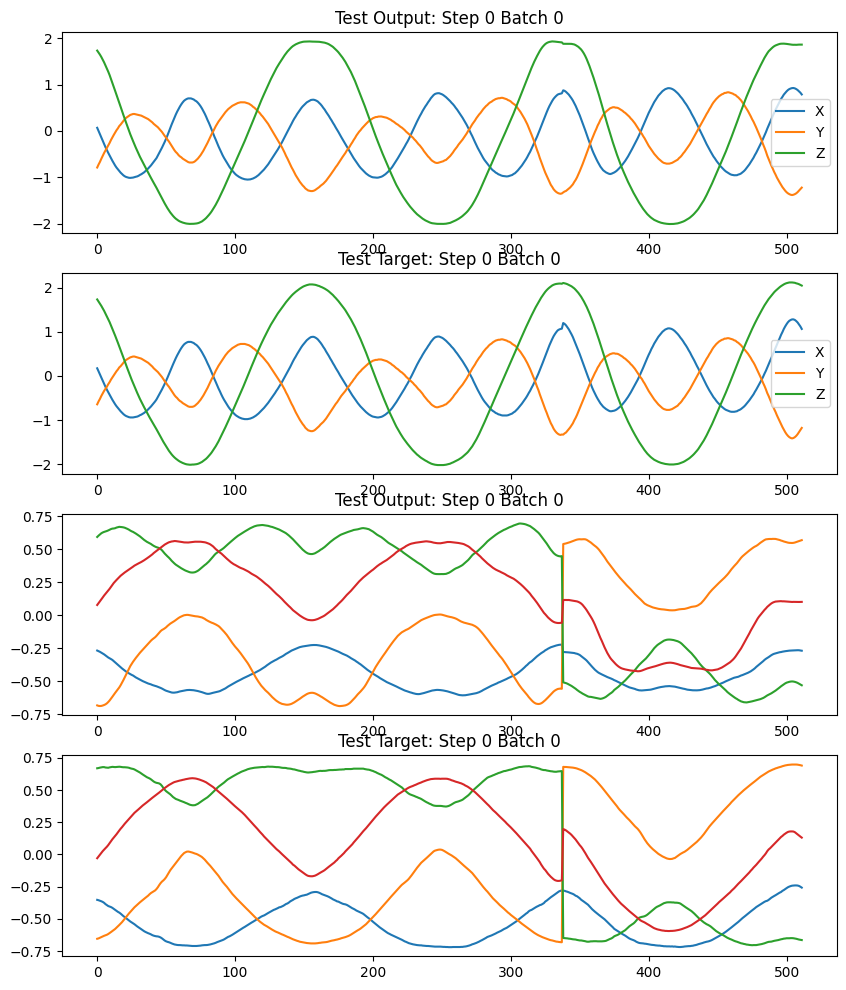

Test Loss: 0.009509858714106182
Test Metric: 0.07271449267864227


In [13]:
import numpy as np
test_Transformer(
    test_loader,
    transformer_model,
    loss_fn,
    metric_loss_fn,
    SAVE_PATH,
    hp.DEVICE,
)

In [9]:
pytorch_total_params = sum(p.numel() for p in transformer_model.parameters())
print(pytorch_total_params)
pytorch_trainable_params = sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)
print(pytorch_trainable_params)

280231
280231
